In [2]:
# CELL 1 — Import & cấu hình chung
import os, glob, time, math, random, tarfile, pickle, gzip, io
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.dpi"] = 120
random.seed(42); np.random.seed(42)

# Thư mục đầu ra
OUT_ROOT = "outputs"
os.makedirs(OUT_ROOT, exist_ok=True)


In [3]:
# CELL 2 — Nạp ảnh từ thư mục (duyệt toàn bộ)
IMG_DIR = "data/images"    # ⚠️ Sửa thành thư mục ảnh của bạn
ENABLE_SYNTH = True        # Fallback: tạo ảnh synthetic nếu không có ảnh

def find_images(root):
    EXTS = (".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff")
    return [p for p in glob.glob(os.path.join(root,"**","*"), recursive=True)
            if p.lower().endswith(EXTS)]

def make_synthetic_images(out_root="data/images_synth", n=30, size=(160,120)):
    os.makedirs(out_root, exist_ok=True)
    W,H = size; paths=[]
    for i in range(n):
        mode = i % 3
        if mode == 0:  # gradient
            x = np.tile(np.linspace(0,255,W,dtype=np.uint8),(H,1))
            img = np.stack([x, np.flipud(x), x//2], axis=2)
        elif mode == 1: # checker
            s=10
            yv,xv=np.indices((H,W))
            board = (((xv//s)+(yv//s))%2)*255
            img = np.stack([board, np.roll(board,3,axis=1), np.roll(board,6,axis=0)], axis=2).astype(np.uint8)
        else:           # noise
            img = np.random.randint(0,256,(H,W,3), dtype=np.uint8)
        p=os.path.join(out_root, f"synth_{i:03d}.png")
        Image.fromarray(img).save(p); paths.append(p)
    return paths

images = find_images(IMG_DIR) if os.path.isdir(IMG_DIR) else []
if len(images)==0 and ENABLE_SYNTH:
    images = make_synthetic_images()
    print(f"⚠️ Không thấy ảnh thật → tạo {len(images)} ảnh synthetic tại data/images_synth")

assert len(images)>0, "Không có ảnh để chạy. Hãy sửa IMG_DIR hoặc bật ENABLE_SYNTH."
print("Ảnh sẵn sàng:", len(images))


Ảnh sẵn sàng: 400


In [4]:
# CELL 3 — Hàm tiện ích: resize, chuẩn hoá, chỉ số, edges

INTERP = {
    "nearest": Image.NEAREST,
    "bilinear": Image.BILINEAR,
    "bicubic": Image.BICUBIC,
    "lanczos": Image.LANCZOS,
}

def resize_direct(img: Image.Image, size=(224,224), method="bilinear"):
    return img.resize(size, INTERP[method])

def resize_letterbox(img: Image.Image, size=(224,224), method="bilinear", pad_color=(0,0,0)):
    Wt,Ht = size; w,h = img.size
    scale = min(Wt/w, Ht/h)
    nw,nh = int(w*scale), int(h*scale)
    img_r = img.resize((nw,nh), INTERP[method])
    canvas = Image.new("RGB",(Wt,Ht), pad_color)
    canvas.paste(img_r, ((Wt-nw)//2,(Ht-nh)//2))
    return canvas

def resize_image(img, size=(224,224), method="bilinear", keep_aspect=True, pad_color=(0,0,0)):
    return resize_letterbox(img,size,method,pad_color) if keep_aspect else resize_direct(img,size,method)

def normalize_01(a):  return a.astype(np.float32)/255.
def normalize_m11(a): return a.astype(np.float32)/127.5 - 1.0

def zscore_fit_transform(X01):
    flat = X01.reshape(len(X01), -1)
    scaler = StandardScaler()
    flat_std = scaler.fit_transform(flat)
    return flat_std.reshape(X01.shape), scaler

def entropy_gray(gray_u8):
    hist, _ = np.histogram(gray_u8.flatten(), bins=256, range=(0,255), density=True)
    hist = hist[hist>0]
    return float(-(hist*np.log2(hist)).sum())

def colorfulness_rgb(rgb_u8):
    R,G,B = rgb_u8[...,0].astype(np.float32), rgb_u8[...,1].astype(np.float32), rgb_u8[...,2].astype(np.float32)
    rg = np.abs(R-G); yb = np.abs(0.5*(R+G)-B)
    return float(np.sqrt(rg.var()+yb.var()) + 0.3*np.sqrt(rg.mean()**2 + yb.mean()**2))

def edges_prewitt(gray_u8):
    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float32)
    ky = np.array([[ 1,1,1],[ 0,0,0],[-1,-1,-1]], dtype=np.float32)
    gx = cv.filter2D(gray_u8, cv.CV_32F, kx)
    gy = cv.filter2D(gray_u8, cv.CV_32F, ky)
    mag = np.sqrt(gx*gx + gy*gy)
    mag = (255 * (mag / (mag.max()+1e-6))).astype(np.uint8)
    return mag

def edges_sobel(gray_u8):
    sx = cv.Sobel(gray_u8, cv.CV_32F, 1, 0, ksize=3)
    sy = cv.Sobel(gray_u8, cv.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(sx*sx + sy*sy)
    mag = (255 * (mag / (mag.max()+1e-6))).astype(np.uint8)
    return mag

def edges_canny(gray_u8, t1=80, t2=160):
    return cv.Canny(gray_u8, t1, t2)

def edge_density(edge_u8):
    return float((edge_u8>0).mean())


In [5]:
# CELL 4 — Cấu hình thí nghiệm
SIZES = [(128,128),(224,224)]   # có thể rút còn (224,224) nếu bộ ảnh rất lớn
METHODS = ["nearest","bilinear","bicubic","lanczos"]
KEEP_ASPECT = True              # True=letterbox; False=resize trực tiếp
N_SAMPLES = None                # ⚠️ None = chạy TẤT CẢ ảnh


In [6]:
# CELL 5 — Benchmark nội suy
def benchmark_interpolation(paths, sizes=SIZES, methods=METHODS, keep_aspect=KEEP_ASPECT, limit=N_SAMPLES):
    if (limit is None) or (limit>=len(paths)): use_paths = paths
    else: use_paths = random.sample(paths, limit)

    rows=[]
    for sz in sizes:
        for m in methods:
            t0=time.time(); cnt=0
            for p in use_paths:
                try:
                    im=Image.open(p).convert("RGB")
                    _=resize_image(im, size=sz, method=m, keep_aspect=keep_aspect)
                    cnt+=1
                except:
                    pass
            dt=time.time()-t0
            rows.append({
                "size": f"{sz[0]}x{sz[1]}",
                "method": m,
                "keep_aspect": keep_aspect,
                "images": cnt,
                "time_sec": round(dt,4),
                "img_per_sec": round(cnt/dt,2) if dt>0 else np.inf
            })
    return pd.DataFrame(rows).sort_values(["size","method"]).reset_index(drop=True)

df_interp = benchmark_interpolation(images)
csv_path = os.path.join(OUT_ROOT, "interp_benchmark.csv")
df_interp.to_csv(csv_path, index=False)
print("✅ Lưu bảng:", csv_path)
df_interp


✅ Lưu bảng: outputs\interp_benchmark.csv


,size,method,keep_aspect,images,time_sec,img_per_sec
0,128x128,bicubic,True,400,0.1358,2945.16
1,128x128,bilinear,True,400,0.1187,3371.08
2,128x128,lanczos,True,400,0.1438,2781.24
3,128x128,nearest,True,400,0.3521,1135.98
4,224x224,bicubic,True,400,0.2469,1619.89
5,224x224,bilinear,True,400,0.1871,2138.30
6,224x224,lanczos,True,400,0.2719,1470.90
7,224x224,nearest,True,400,0.1132,3534.35


In [7]:
# CELL 6 — So sánh chuẩn hoá
def collect_norm_stats(paths, size=(224,224), method="bilinear", keep_aspect=KEEP_ASPECT, limit=N_SAMPLES):
    if (limit is None) or (limit>=len(paths)): use_paths=paths
    else: use_paths=random.sample(paths, limit)

    X=[]
    for p in use_paths:
        im=Image.open(p).convert("RGB")
        imr=resize_image(im, size=size, method=method, keep_aspect=keep_aspect)
        X.append(np.asarray(imr))
    X = np.stack(X)               # (N,H,W,3) uint8

    X01 = X.astype(np.float32)/255.
    Xm11 = X.astype(np.float32)/127.5 - 1.0
    Xstd, scaler = zscore_fit_transform(X01.copy())

    def stats(arr, name):
        return {
            "repr": name,
            "mean": float(arr.mean()),
            "std":  float(arr.std()),
            "min":  float(arr.min()),
            "max":  float(arr.max())
        }
    rows=[]
    rows.append(stats(X01,  "[0,1]"))
    rows.append(stats(Xm11, "[-1,1]"))
    rows.append(stats(Xstd, "Z-score"))
    return pd.DataFrame(rows), {"X01":X01, "Xm11":Xm11, "Xstd":Xstd}

df_norm, packs_norm = collect_norm_stats(images, size=(224,224), method="bilinear", keep_aspect=True)
csv_path = os.path.join(OUT_ROOT, "normalization_stats.csv")
df_norm.to_csv(csv_path, index=False)
print("✅ Lưu bảng:", csv_path)
df_norm


✅ Lưu bảng: outputs\normalization_stats.csv


,repr,mean,std,min,max
0,"[0,1]",4.837755e-01,0.249339,0.000000,1.000000
1,"[-1,1]",-3.245036e-02,0.498678,-1.000000,1.000000
2,Z-score,1.249670e-08,1.000000,-2.478769,2.734767


,method,edge density,time (ms)
0,Sobel,0.971050,0.064288
1,Prewitt,0.971450,0.089606
2,Canny,0.233418,0.097883
3,<MEAN>,0.725306,0.083926


✅ Saved: outputs\edge_density_comparison.csv


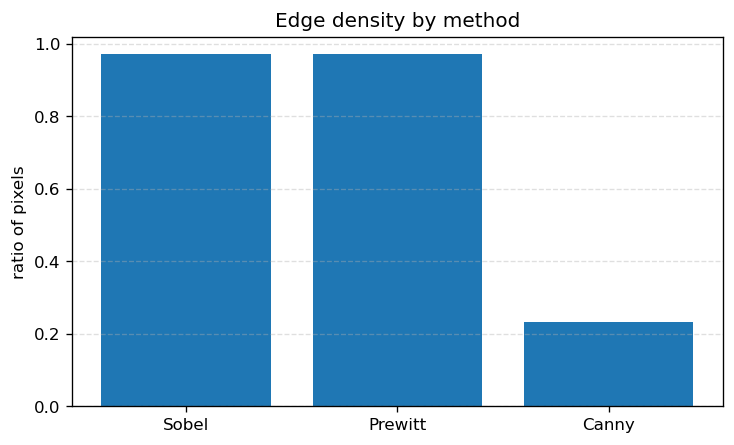

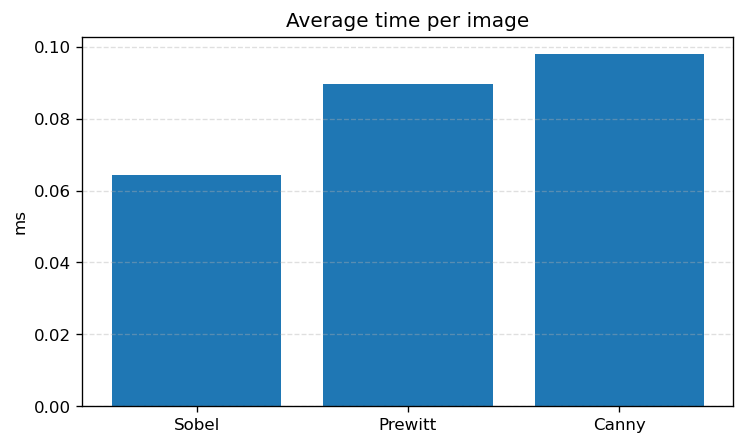

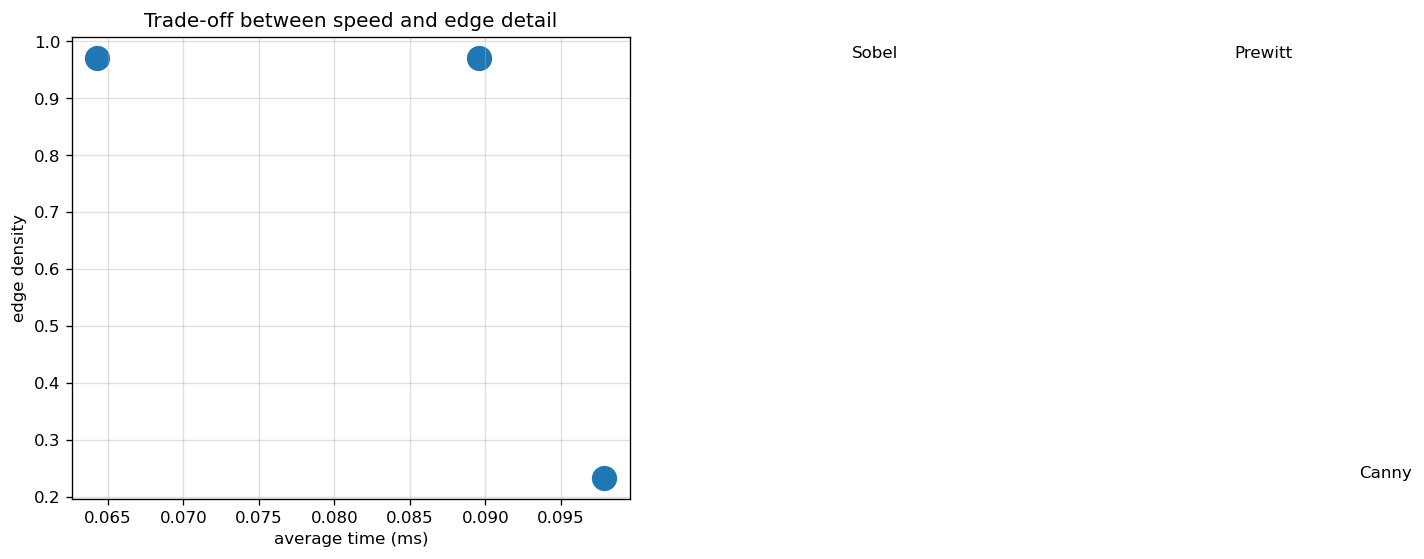

In [22]:
# CELL — Compare 3 edge detectors: Sobel, Prewitt, Canny (fixed)
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image, ImageOps

def edge_density(edge_img):
    """Ratio of edge pixels over total pixels."""
    return np.count_nonzero(edge_img) / edge_img.size

def benchmark_edges(gray_images, repeat=1):
    """Compute mean Edge Density and Time per image for 3 algorithms."""
    results = []
    algs = [("Sobel", edges_sobel),
            ("Prewitt", edges_prewitt),
            ("Canny", edges_canny)]
    for name, func in algs:
        t0 = time.time()
        densities = []
        for _ in range(repeat):
            for g in gray_images:
                e = func(g)
                densities.append(edge_density(e))
        t1 = time.time()
        elapsed_ms = (t1 - t0) * 1000 / (len(gray_images) * repeat)
        results.append({
            "method": name,
            "edge density": float(np.mean(densities)),
            "time (ms)": float(elapsed_ms)
        })
    df = pd.DataFrame(results)
    # Append <MEAN> row using the correct column names
    mean_row = {
        "method": "<MEAN>",
        "edge density": df["edge density"].mean(),
        "time (ms)": df["time (ms)"].mean()
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)
    return df

# ==== Run on a subset (or all) images ====
gray_images = [np.asarray(ImageOps.grayscale(Image.open(p).convert("RGB")))
               for p in images[:200]]  # adjust 200 -> None for all

df_edge = benchmark_edges(gray_images)
display(df_edge)

# ==== Save CSV ====
out_csv = os.path.join(OUT_ROOT, "edge_density_comparison.csv")
df_edge.to_csv(out_csv, index=False)
print("✅ Saved:", out_csv)

# ==== Bar charts (exclude <MEAN>) ====
df_plot = df_edge[df_edge["method"] != "<MEAN>"]

plt.figure(figsize=(7,4))
plt.bar(df_plot["method"], df_plot["edge density"])
plt.title("Edge density by method")
plt.ylabel("ratio of pixels")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(df_plot["method"], df_plot["time (ms)"])
plt.title("Average time per image")
plt.ylabel("ms")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

# ==== Scatter: speed vs. edge detail (exclude <MEAN>) ====
plt.figure(figsize=(6,5))
plt.scatter(df_plot["time (ms)"], df_plot["edge density"], s=200)
for _, row in df_plot.iterrows():
    plt.text(row["time (ms)"]+0.05, row["edge density"], row["method"], fontsize=10)
plt.xlabel("average time (ms)")
plt.ylabel("edge density")
plt.title("Trade-off between speed and edge detail")
plt.grid(alpha=0.4)
plt.show()


In [8]:
# CELL 7 — So sánh Sobel/Prewitt/Canny
def benchmark_edges(paths, size=(224,224), method="bilinear", keep_aspect=KEEP_ASPECT, limit=N_SAMPLES):
    if (limit is None) or (limit>=len(paths)): use_paths=paths
    else: use_paths=random.sample(paths, limit)

    rows=[]
    for p in use_paths:
        im=Image.open(p).convert("RGB")
        imr=resize_image(im, size=size, method=method, keep_aspect=keep_aspect)
        g = np.asarray(ImageOps.grayscale(imr))

        # Sobel
        t0=time.time(); e_s = edges_sobel(g);  t_s=time.time()-t0
        # Prewitt
        t0=time.time(); e_p = edges_prewitt(g);t_p=time.time()-t0
        # Canny
        t0=time.time(); e_c = edges_canny(g);  t_c=time.time()-t0

        rows.append({
            "file": os.path.basename(p),
            "edge_sobel_density":  edge_density(e_s),
            "edge_prewitt_density":edge_density(e_p),
            "edge_canny_density":  edge_density(e_c),
            "time_sobel_ms":  round(1000*t_s,2),
            "time_prewitt_ms":round(1000*t_p,2),
            "time_canny_ms":  round(1000*t_c,2),
        })
    df = pd.DataFrame(rows)
    # Thêm hàng trung bình
    avg = pd.DataFrame([{
        "file": "<MEAN>",
        "edge_sobel_density":  df.edge_sobel_density.mean(),
        "edge_prewitt_density":df.edge_prewitt_density.mean(),
        "edge_canny_density":  df.edge_canny_density.mean(),
        "time_sobel_ms":  df.time_sobel_ms.mean(),
        "time_prewitt_ms":df.time_prewitt_ms.mean(),
        "time_canny_ms":  df.time_canny_ms.mean(),
    }])
    return pd.concat([df, avg], ignore_index=True)

df_edges = benchmark_edges(images, size=(224,224), method="bilinear", keep_aspect=True)
csv_path = os.path.join(OUT_ROOT, "edges_benchmark.csv")
df_edges.to_csv(csv_path, index=False)
print("✅ Lưu bảng:", csv_path)
df_edges


✅ Lưu bảng: outputs\edges_benchmark.csv


,file,edge_sobel_density,edge_prewitt_density,edge_canny_density,time_sobel_ms,time_prewitt_ms,time_canny_ms
0,img_00000.png,0.921735,0.921735,0.000638,13.4600,4.0000,10.470
1,img_00002.png,0.953703,0.953743,0.000000,1.0000,0.0000,2.000
2,img_00029.png,0.341936,0.341956,0.000000,0.0000,2.0100,0.000
3,img_00048.png,0.505481,0.505461,0.006178,0.0000,0.0000,2.010
4,img_00052.png,0.935806,0.935786,0.000000,3.4000,0.0000,0.000
...,...,...,...,...,...,...,...
396,img_00179.png,0.976842,0.976861,0.006118,1.0000,0.0000,0.000
397,img_00180.png,0.975207,0.975426,0.005680,0.0000,0.0000,0.000
398,img_00191.png,0.923649,0.923649,0.004664,0.0000,1.0000,0.000
399,img_00194.png,0.950355,0.950335,0.010085,1.0000,0.0000,0.000


In [8]:
# CELL 7 — So sánh Sobel/Prewitt/Canny
def benchmark_edges(paths, size=(224,224), method="bilinear", keep_aspect=KEEP_ASPECT, limit=N_SAMPLES):
    if (limit is None) or (limit>=len(paths)): use_paths=paths
    else: use_paths=random.sample(paths, limit)

    rows=[]
    for p in use_paths:
        im=Image.open(p).convert("RGB")
        imr=resize_image(im, size=size, method=method, keep_aspect=keep_aspect)
        g = np.asarray(ImageOps.grayscale(imr))

        # Sobel
        t0=time.time(); e_s = edges_sobel(g);  t_s=time.time()-t0
        # Prewitt
        t0=time.time(); e_p = edges_prewitt(g);t_p=time.time()-t0
        # Canny
        t0=time.time(); e_c = edges_canny(g);  t_c=time.time()-t0

        rows.append({
            "file": os.path.basename(p),
            "edge_sobel_density":  edge_density(e_s),
            "edge_prewitt_density":edge_density(e_p),
            "edge_canny_density":  edge_density(e_c),
            "time_sobel_ms":  round(1000*t_s,2),
            "time_prewitt_ms":round(1000*t_p,2),
            "time_canny_ms":  round(1000*t_c,2),
        })
    df = pd.DataFrame(rows)
    # Thêm hàng trung bình
    avg = pd.DataFrame([{
        "file": "<MEAN>",
        "edge_sobel_density":  df.edge_sobel_density.mean(),
        "edge_prewitt_density":df.edge_prewitt_density.mean(),
        "edge_canny_density":  df.edge_canny_density.mean(),
        "time_sobel_ms":  df.time_sobel_ms.mean(),
        "time_prewitt_ms":df.time_prewitt_ms.mean(),
        "time_canny_ms":  df.time_canny_ms.mean(),
    }])
    return pd.concat([df, avg], ignore_index=True)

df_edges = benchmark_edges(images, size=(224,224), method="bilinear", keep_aspect=True)
csv_path = os.path.join(OUT_ROOT, "edges_benchmark.csv")
df_edges.to_csv(csv_path, index=False)
print("✅ Lưu bảng:", csv_path)
df_edges


✅ Lưu bảng: outputs\edges_benchmark.csv


,file,edge_sobel_density,edge_prewitt_density,edge_canny_density,time_sobel_ms,time_prewitt_ms,time_canny_ms
0,img_00000.png,0.921735,0.921735,0.000638,13.4600,4.0000,10.470
1,img_00002.png,0.953703,0.953743,0.000000,1.0000,0.0000,2.000
2,img_00029.png,0.341936,0.341956,0.000000,0.0000,2.0100,0.000
3,img_00048.png,0.505481,0.505461,0.006178,0.0000,0.0000,2.010
4,img_00052.png,0.935806,0.935786,0.000000,3.4000,0.0000,0.000
...,...,...,...,...,...,...,...
396,img_00179.png,0.976842,0.976861,0.006118,1.0000,0.0000,0.000
397,img_00180.png,0.975207,0.975426,0.005680,0.0000,0.0000,0.000
398,img_00191.png,0.923649,0.923649,0.004664,0.0000,1.0000,0.000
399,img_00194.png,0.950355,0.950335,0.010085,1.0000,0.0000,0.000


In [9]:
# CELL 8 — Chất lượng nội suy (down→up)

def mse(a,b): return float(np.mean((a.astype(np.float32)-b.astype(np.float32))**2))
def psnr(mse_val, max_val=255.0): 
    return float(10*np.log10((max_val**2)/(mse_val+1e-9)))

def quality_interp(paths, size_down=(96,96), size_up=(224,224), methods=METHODS, keep_aspect=KEEP_ASPECT, limit=N_SAMPLES):
    if (limit is None) or (limit>=len(paths)): use_paths=paths
    else: use_paths=random.sample(paths, limit)

    rows=[]
    for p in use_paths:
        im = Image.open(p).convert("RGB")
        ref = resize_image(im, size=size_up, method="lanczos", keep_aspect=keep_aspect)   # chọn Lanczos làm tham chiếu
        ref_np = np.asarray(ref)

        base_small = resize_image(im, size=size_down, method="bilinear", keep_aspect=keep_aspect)
        for m in methods:
            up = base_small.resize(size_up, INTERP[m])
            up_np = np.asarray(up)
            m_mse = mse(ref_np, up_np)
            m_psnr = psnr(m_mse)
            rows.append({"method": m, "MSE": m_mse, "PSNR": m_psnr})
    df = pd.DataFrame(rows)
    return df.groupby("method", as_index=False).agg({"MSE":"mean", "PSNR":"mean"}).sort_values("MSE")

df_interp_quality = quality_interp(images)
csv_path = os.path.join(OUT_ROOT, "interp_quality.csv")
df_interp_quality.to_csv(csv_path, index=False)
print("✅ Lưu bảng:", csv_path)
df_interp_quality


✅ Lưu bảng: outputs\interp_quality.csv


,method,MSE,PSNR
0,bicubic,18.716853,36.018771
2,lanczos,19.104634,35.926663
1,bilinear,20.412203,35.647416
3,nearest,27.488572,34.326305


In [10]:
# CELL 9 — Gộp bảng quyết định & xuất CSV tổng hợp

# 1) Nội suy: tốc độ + chất lượng
df_i = df_interp.copy()
df_q = df_interp_quality.copy()
df_iq = df_i.merge(df_q, how="left", on="method").sort_values(["size","PSNR"], ascending=[True,False])

# 2) Chuẩn hoá
df_n = df_norm.copy()

# 3) Edge
df_e = df_edges.copy()

# Xuất CSV
df_iq.to_csv(os.path.join(OUT_ROOT, "decision_interpolation.csv"), index=False)
df_n.to_csv(os.path.join(OUT_ROOT, "decision_normalization.csv"), index=False)
df_e.to_csv(os.path.join(OUT_ROOT, "decision_edges.csv"), index=False)

print("✅ Lưu bảng decision_* vào:", OUT_ROOT)
df_iq


✅ Lưu bảng decision_* vào: outputs


,size,method,keep_aspect,images,time_sec,img_per_sec,MSE,PSNR
0,128x128,bicubic,True,400,0.1358,2945.16,18.716853,36.018771
2,128x128,lanczos,True,400,0.1438,2781.24,19.104634,35.926663
1,128x128,bilinear,True,400,0.1187,3371.08,20.412203,35.647416
3,128x128,nearest,True,400,0.3521,1135.98,27.488572,34.326305
4,224x224,bicubic,True,400,0.2469,1619.89,18.716853,36.018771
6,224x224,lanczos,True,400,0.2719,1470.90,19.104634,35.926663
5,224x224,bilinear,True,400,0.1871,2138.30,20.412203,35.647416
7,224x224,nearest,True,400,0.1132,3534.35,27.488572,34.326305


In [11]:
# CELL 10 — Lưu 12 ảnh minh hoạ
OUT_DEMO = os.path.join(OUT_ROOT, "demo_export")
os.makedirs(OUT_DEMO, exist_ok=True)

sample_paths = images[:12]  # lấy 12 ảnh đầu
for k, p in enumerate(sample_paths):
    im = Image.open(p).convert("RGB")
    imr = resize_image(im, size=(224,224), method="bilinear", keep_aspect=True)
    gray = ImageOps.grayscale(imr)
    e1 = edges_sobel(np.asarray(gray))
    e2 = edges_prewitt(np.asarray(gray))
    e3 = edges_canny(np.asarray(gray))
    Image.fromarray(np.asarray(imr)).save(os.path.join(OUT_DEMO, f"rgb_{k:02d}.png"))
    Image.fromarray(np.asarray(gray)).save(os.path.join(OUT_DEMO, f"gray_{k:02d}.png"))
    Image.fromarray(e1).save(os.path.join(OUT_DEMO, f"edge_sobel_{k:02d}.png"))
    Image.fromarray(e2).save(os.path.join(OUT_DEMO, f"edge_prewitt_{k:02d}.png"))
    Image.fromarray(e3).save(os.path.join(OUT_DEMO, f"edge_canny_{k:02d}.png"))
print("✅ Lưu ảnh minh hoạ vào:", OUT_DEMO)


✅ Lưu ảnh minh hoạ vào: outputs\demo_export


In [12]:
# CELL 11 — Tiện ích vẽ & thư mục lưu hình
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FIG_DIR = os.path.join(OUT_ROOT, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

def save_show(fig, name):
    path = os.path.join(FIG_DIR, name)
    fig.savefig(path, bbox_inches="tight", dpi=200)
    plt.show()
    print("✅ Saved figure:", path)


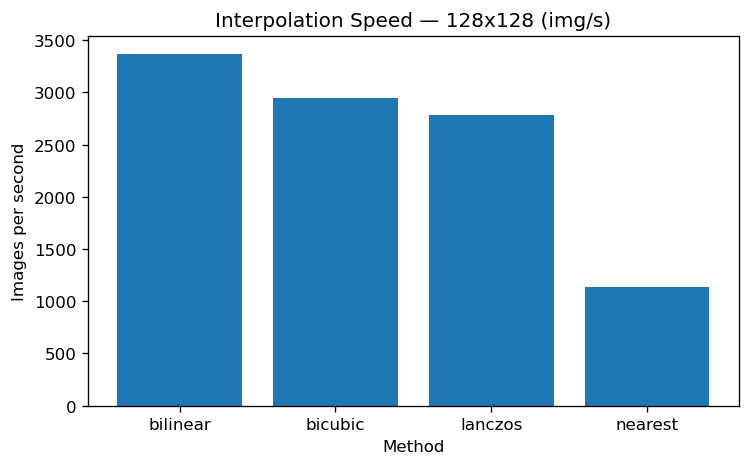

✅ Saved figure: outputs\figs\interp_speed_128_128.png


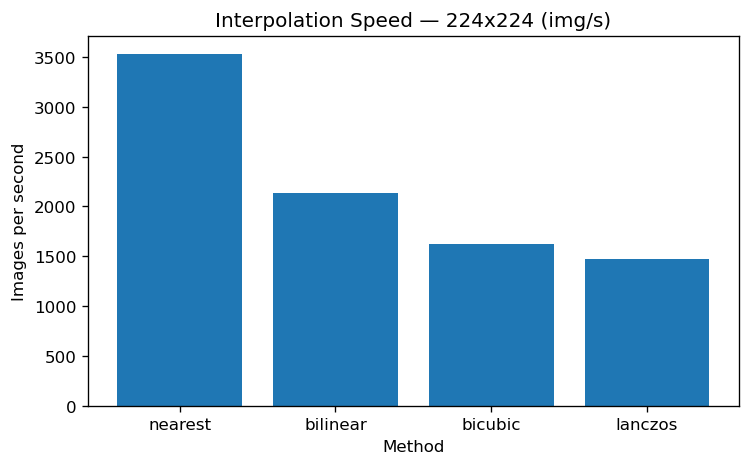

✅ Saved figure: outputs\figs\interp_speed_224_224.png


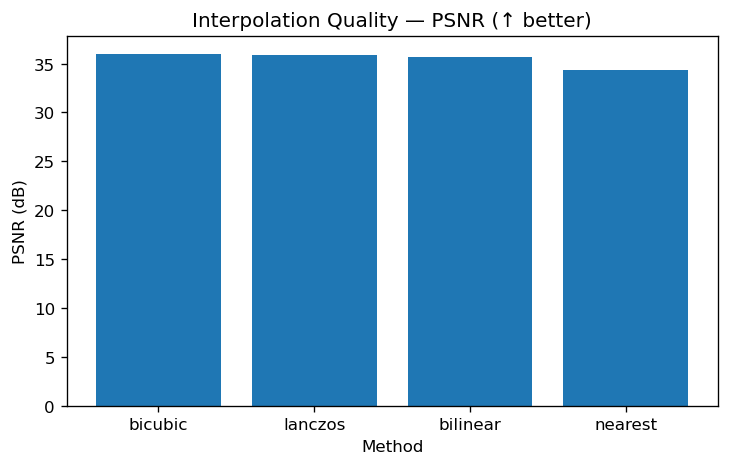

✅ Saved figure: outputs\figs\interp_quality_psnr.png


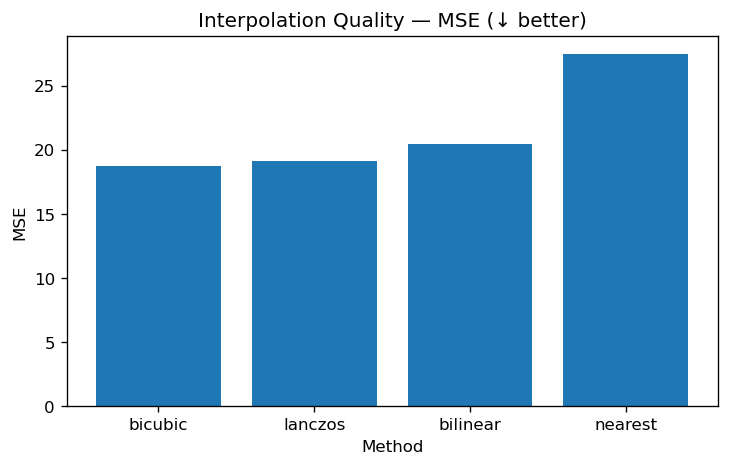

✅ Saved figure: outputs\figs\interp_quality_mse.png


In [13]:
# CELL 12 — Biểu đồ nội suy: tốc độ (img/s) & chất lượng (PSNR, MSE)

# Đọc bảng đã lưu
df_interp = pd.read_csv(os.path.join(OUT_ROOT, "interp_benchmark.csv"))
df_quality = pd.read_csv(os.path.join(OUT_ROOT, "interp_quality.csv"))

# 12.1 — SPEED: img_per_sec theo method cho từng size
for sz, g in df_interp.groupby("size"):
    fig, ax = plt.subplots(figsize=(7,4))
    g2 = g.sort_values("img_per_sec", ascending=False)
    ax.bar(g2["method"], g2["img_per_sec"])
    ax.set_title(f"Interpolation Speed — {sz} (img/s)")
    ax.set_xlabel("Method")
    ax.set_ylabel("Images per second")
    save_show(fig, f"interp_speed_{sz.replace('x','_')}.png")

# 12.2 — QUALITY: PSNR trung bình theo method (cao hơn tốt hơn)
fig, ax = plt.subplots(figsize=(7,4))
g = df_quality.sort_values("PSNR", ascending=False)
ax.bar(g["method"], g["PSNR"])
ax.set_title("Interpolation Quality — PSNR (↑ better)")
ax.set_xlabel("Method")
ax.set_ylabel("PSNR (dB)")
save_show(fig, "interp_quality_psnr.png")

# 12.3 — QUALITY: MSE trung bình theo method (thấp hơn tốt hơn)
fig, ax = plt.subplots(figsize=(7,4))
g = df_quality.sort_values("MSE", ascending=True)
ax.bar(g["method"], g["MSE"])
ax.set_title("Interpolation Quality — MSE (↓ better)")
ax.set_xlabel("Method")
ax.set_ylabel("MSE")
save_show(fig, "interp_quality_mse.png")


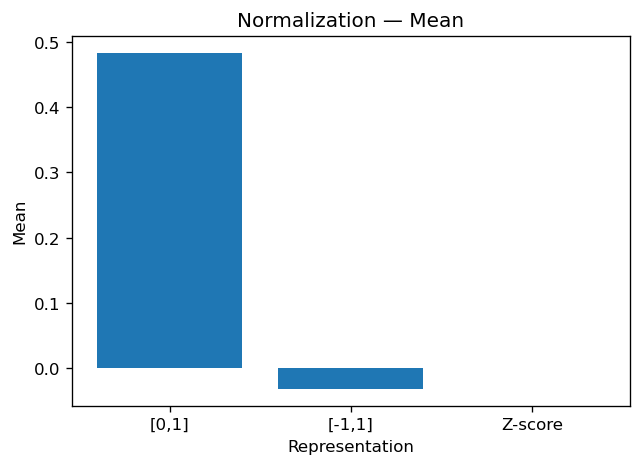

✅ Saved figure: outputs\figs\norm_mean.png


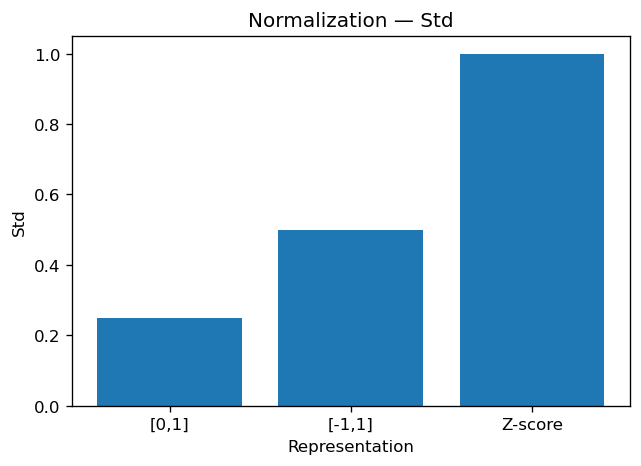

✅ Saved figure: outputs\figs\norm_std.png


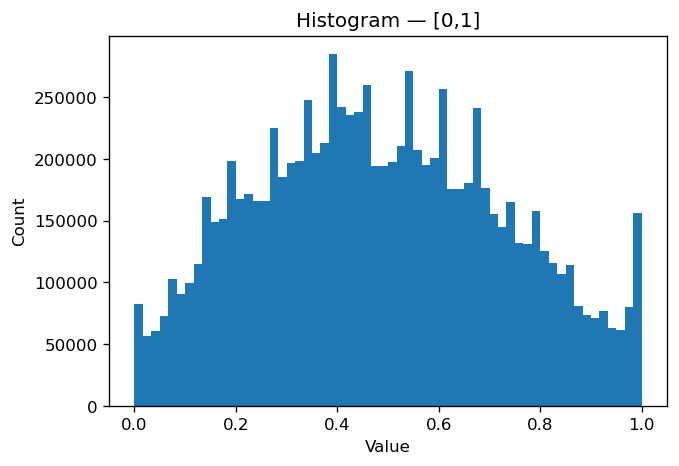

✅ Saved figure: outputs\figs\norm_hist_01.png


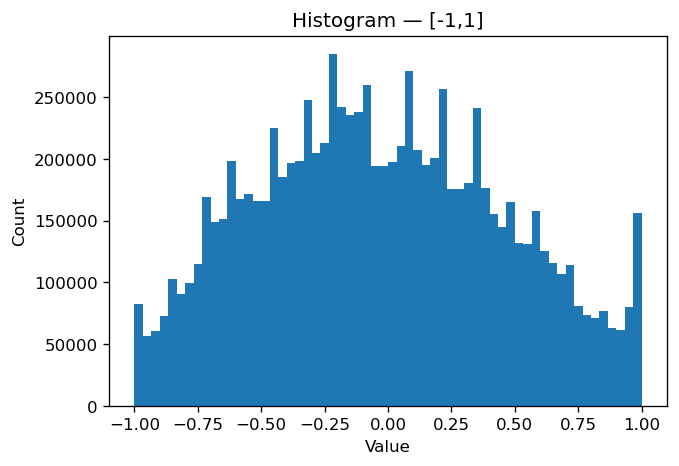

✅ Saved figure: outputs\figs\norm_hist_m11.png


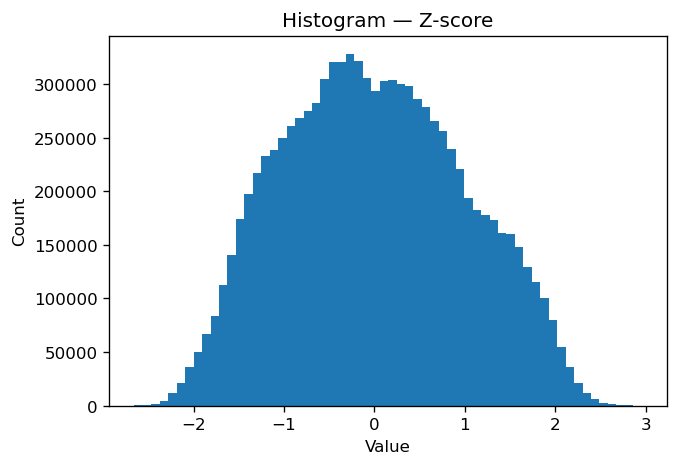

✅ Saved figure: outputs\figs\norm_hist_zscore.png


In [14]:
# CELL 13 — Biểu đồ chuẩn hoá: mean/std + histogram minh hoạ

df_norm = pd.read_csv(os.path.join(OUT_ROOT, "normalization_stats.csv"))

# 13.1 — Mean theo representation
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(df_norm["repr"], df_norm["mean"])
ax.set_title("Normalization — Mean")
ax.set_xlabel("Representation")
ax.set_ylabel("Mean")
save_show(fig, "norm_mean.png")

# 13.2 — Std theo representation
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(df_norm["repr"], df_norm["std"])
ax.set_title("Normalization — Std")
ax.set_xlabel("Representation")
ax.set_ylabel("Std")
save_show(fig, "norm_std.png")

# 13.3 — Histogram minh hoạ ba dạng chuẩn hoá (lấy lại 1 batch để trực quan)
#      (Không dùng seaborn; mỗi chart riêng lẻ)
def recompute_norm_batch(paths, n=64, size=(224,224), method="bilinear", keep_aspect=True):
    sel = paths if len(paths) <= n else random.sample(paths, n)
    X=[]
    for p in sel:
        im = Image.open(p).convert("RGB")
        imr = resize_image(im, size=size, method=method, keep_aspect=keep_aspect)
        X.append(np.asarray(imr))
    X = np.stack(X)
    X01  = X.astype(np.float32)/255.
    Xm11 = X.astype(np.float32)/127.5 - 1.0
    Xstd, _ = zscore_fit_transform(X01.copy())
    return X01, Xm11, Xstd

X01, Xm11, Xstd = recompute_norm_batch(images)

# Histogram [0,1]
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(X01.flatten(), bins=60)
ax.set_title("Histogram — [0,1]")
ax.set_xlabel("Value")
ax.set_ylabel("Count")
save_show(fig, "norm_hist_01.png")

# Histogram [-1,1]
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(Xm11.flatten(), bins=60)
ax.set_title("Histogram — [-1,1]")
ax.set_xlabel("Value")
ax.set_ylabel("Count")
save_show(fig, "norm_hist_m11.png")

# Histogram Z-score
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(Xstd.flatten(), bins=60)
ax.set_title("Histogram — Z-score")
ax.set_xlabel("Value")
ax.set_ylabel("Count")
save_show(fig, "norm_hist_zscore.png")


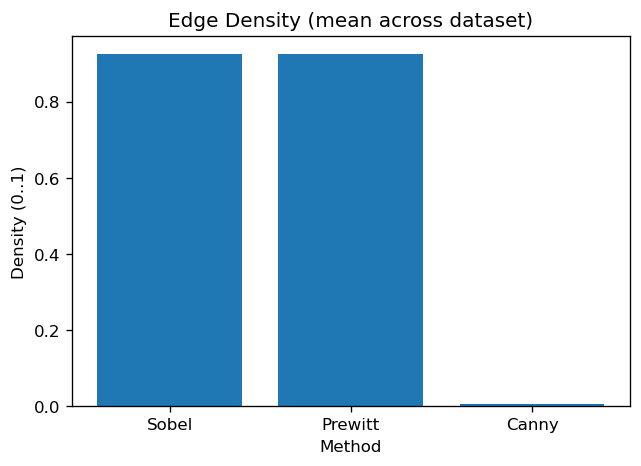

✅ Saved figure: outputs\figs\edge_density_mean.png


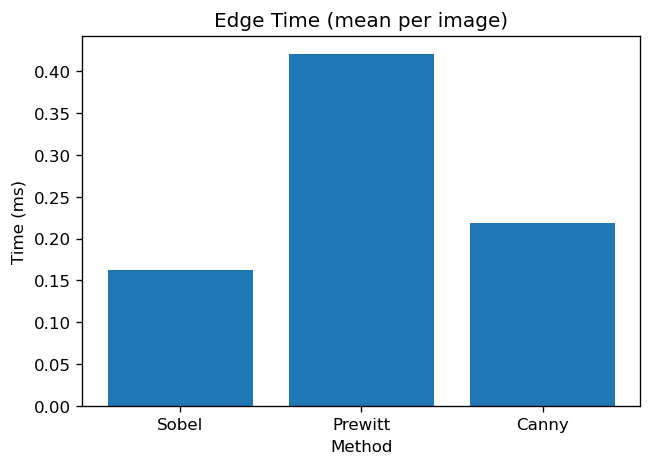

✅ Saved figure: outputs\figs\edge_time_mean.png


In [15]:
# CELL 14 — Biểu đồ edge detectors: density & time

df_edges = pd.read_csv(os.path.join(OUT_ROOT, "edges_benchmark.csv"))

# Loại hàng <MEAN> để vẽ phân phối theo từng ảnh
df_img = df_edges[df_edges["file"] != "<MEAN>"].copy()
df_mean = df_edges[df_edges["file"] == "<MEAN>"].copy()

# 14.1 — Trung bình mật độ biên theo thuật toán (cột <MEAN>)
fig, ax = plt.subplots(figsize=(6,4))
methods = ["edge_sobel_density","edge_prewitt_density","edge_canny_density"]
vals = [float(df_mean[m].values[0]) for m in methods]
ax.bar(["Sobel","Prewitt","Canny"], vals)
ax.set_title("Edge Density (mean across dataset)")
ax.set_xlabel("Method")
ax.set_ylabel("Density (0..1)")
save_show(fig, "edge_density_mean.png")

# 14.2 — Trung bình thời gian theo thuật toán
fig, ax = plt.subplots(figsize=(6,4))
methods_t = ["time_sobel_ms","time_prewitt_ms","time_canny_ms"]
vals_t = [float(df_mean[m].values[0]) for m in methods_t]
ax.bar(["Sobel","Prewitt","Canny"], vals_t)
ax.set_title("Edge Time (mean per image)")
ax.set_xlabel("Method")
ax.set_ylabel("Time (ms)")
save_show(fig, "edge_time_mean.png")


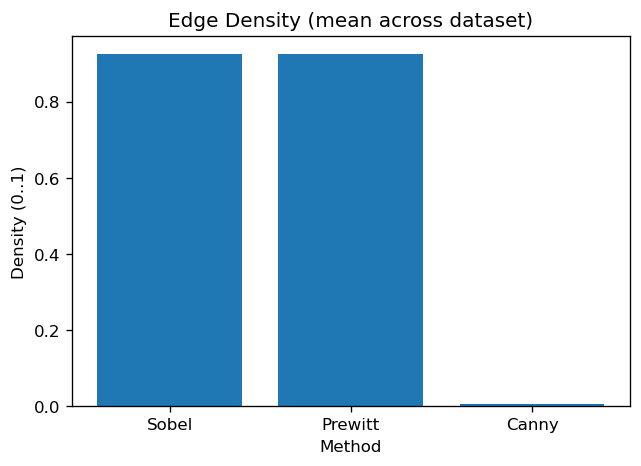

✅ Saved figure: outputs\figs\edge_density_mean.png


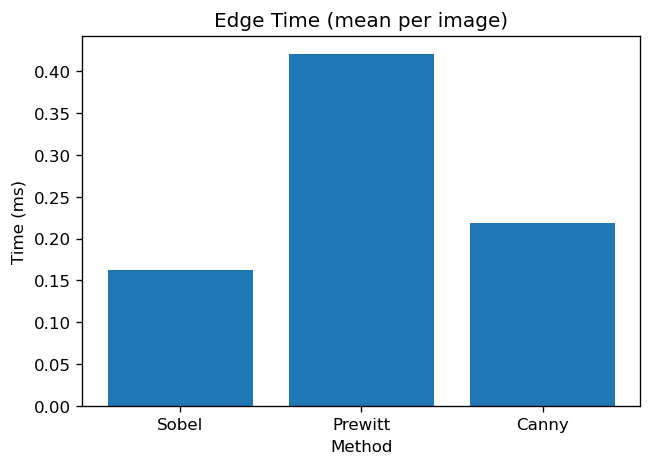

✅ Saved figure: outputs\figs\edge_time_mean.png


In [16]:
# CELL 14 — Biểu đồ edge detectors: density & time

df_edges = pd.read_csv(os.path.join(OUT_ROOT, "edges_benchmark.csv"))

# Loại hàng <MEAN> để vẽ phân phối theo từng ảnh
df_img = df_edges[df_edges["file"] != "<MEAN>"].copy()
df_mean = df_edges[df_edges["file"] == "<MEAN>"].copy()

# 14.1 — Trung bình mật độ biên theo thuật toán (cột <MEAN>)
fig, ax = plt.subplots(figsize=(6,4))
methods = ["edge_sobel_density","edge_prewitt_density","edge_canny_density"]
vals = [float(df_mean[m].values[0]) for m in methods]
ax.bar(["Sobel","Prewitt","Canny"], vals)
ax.set_title("Edge Density (mean across dataset)")
ax.set_xlabel("Method")
ax.set_ylabel("Density (0..1)")
save_show(fig, "edge_density_mean.png")

# 14.2 — Trung bình thời gian theo thuật toán
fig, ax = plt.subplots(figsize=(6,4))
methods_t = ["time_sobel_ms","time_prewitt_ms","time_canny_ms"]
vals_t = [float(df_mean[m].values[0]) for m in methods_t]
ax.bar(["Sobel","Prewitt","Canny"], vals_t)
ax.set_title("Edge Time (mean per image)")
ax.set_xlabel("Method")
ax.set_ylabel("Time (ms)")
save_show(fig, "edge_time_mean.png")


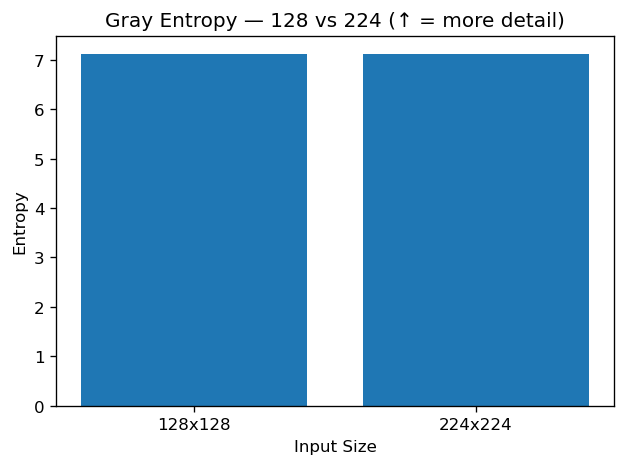

✅ Saved figure: outputs\figs\size_entropy_compare.png


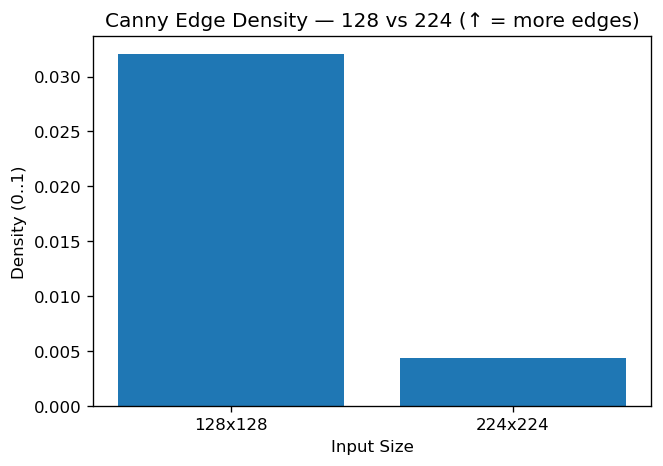

✅ Saved figure: outputs\figs\size_edge_density_compare.png


In [17]:
# CELL 15 — Entropy & Edge density: 128 vs 224

def dataset_gray_entropy_and_canny_density(paths, size, method="bilinear", keep_aspect=True, limit=None):
    sel = paths if (limit is None or limit >= len(paths)) else random.sample(paths, limit)
    ent_list, den_list = [], []
    for p in sel:
        im = Image.open(p).convert("RGB")
        imr = resize_image(im, size=size, method=method, keep_aspect=keep_aspect)
        g   = np.asarray(ImageOps.grayscale(imr))
        e   = edges_canny(g)
        ent_list.append(entropy_gray(g))
        den_list.append(edge_density(e))
    return float(np.mean(ent_list)), float(np.mean(den_list))

sizes_to_test = [(128,128),(224,224)]
ent_vals, den_vals, labels = [], [], []
for sz in sizes_to_test:
    ent, den = dataset_gray_entropy_and_canny_density(images, size=sz, method="bilinear", keep_aspect=True, limit=None)
    ent_vals.append(ent); den_vals.append(den); labels.append(f"{sz[0]}x{sz[1]}")

# 15.1 — Entropy
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(labels, ent_vals)
ax.set_title("Gray Entropy — 128 vs 224 (↑ = more detail)")
ax.set_xlabel("Input Size")
ax.set_ylabel("Entropy")
save_show(fig, "size_entropy_compare.png")

# 15.2 — Edge density (Canny)
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(labels, den_vals)
ax.set_title("Canny Edge Density — 128 vs 224 (↑ = more edges)")
ax.set_xlabel("Input Size")
ax.set_ylabel("Density (0..1)")
save_show(fig, "size_edge_density_compare.png")


In [19]:
# CELL — EXPORT FULL: đa kích thước + 4 nội suy + 3 chuẩn hoá + edges
import os, random, numpy as np, pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# ========= CẤU HÌNH =========
N_EXAMPLES   = 8                         # số ảnh demo muốn xuất
SIZES_STEPS  = [(128,128), (224,224)]    # so sánh 128 & 224
METHODS_STEPS= ["nearest","bilinear","bicubic","lanczos"]  # 4 nội suy
KEEP_ASPECT  = True                      # letterbox (giữ tỉ lệ)
OUT_STEPS    = os.path.join(OUT_ROOT, "steps_export_full")
os.makedirs(OUT_STEPS, exist_ok=True)

# ========= TIỆN ÍCH ẢNH HOÁ =========
def float01_to_u8(x01):
    x = np.clip(x01*255.0, 0, 255).astype(np.uint8)
    return x

def m11_to_u8(xm11):
    # map [-1,1] -> [0,255] để xem
    x01 = (xm11 + 1.0) * 0.5
    return float01_to_u8(x01)

def zscore_to_u8(z):
    # ảnh hoá Z-score bằng min-max theo từng ảnh để nhìn tương phản
    zmin, zmax = np.min(z), np.max(z)
    if zmax - zmin < 1e-6:
        return np.zeros_like(z, dtype=np.uint8)
    x01 = (z - zmin) / (zmax - zmin)
    return float01_to_u8(x01)

# ========= CHỌN ẢNH =========
sel_paths = images if len(images) <= N_EXAMPLES else random.sample(images, N_EXAMPLES)

# ========= XUẤT =========
manifest_rows = []

for idx, p in enumerate(sel_paths):
    im = Image.open(p).convert("RGB")
    base_dir = os.path.join(OUT_STEPS, f"img_{idx:03d}")
    os.makedirs(base_dir, exist_ok=True)

    # 0) Gốc
    out_orig = os.path.join(base_dir, "00_original.png")
    im.save(out_orig)
    manifest_rows.append({"id": idx, "method": "-", "size": "-", "step": "original", "path": out_orig})

    # Lặp theo 4 nội suy
    for meth in METHODS_STEPS:
        meth_dir = os.path.join(base_dir, f"m_{meth}")
        os.makedirs(meth_dir, exist_ok=True)

        for sz in SIZES_STEPS:
            # 1) Resize (theo thuật toán meth)
            imr = resize_image(im, size=sz, method=meth, keep_aspect=KEEP_ASPECT)
            rgb_u8 = np.asarray(imr)
            out_rgb = os.path.join(meth_dir, f"10_rgb_{sz[0]}x{sz[1]}.png")
            Image.fromarray(rgb_u8).save(out_rgb)
            manifest_rows.append({"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "rgb", "path": out_rgb})

            # 2) Gray
            gray_u8 = np.asarray(ImageOps.grayscale(imr))
            out_gray = os.path.join(meth_dir, f"20_gray_{sz[0]}x{sz[1]}.png")
            Image.fromarray(gray_u8).save(out_gray)
            manifest_rows.append({"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "gray", "path": out_gray})

            # 3) Normalize [0,1] (ảnh hoá)
            rgb01 = normalize_01(rgb_u8)
            out_norm01 = os.path.join(meth_dir, f"30_norm01_{sz[0]}x{sz[1]}.png")
            Image.fromarray(float01_to_u8(rgb01)).save(out_norm01)
            manifest_rows.append({"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "[0,1](vis)", "path": out_norm01})

            # 4) Normalize [-1,1] (ảnh hoá)
            rgbm11 = rgb_u8.astype(np.float32)/127.5 - 1.0
            out_normm11 = os.path.join(meth_dir, f"31_normm11_{sz[0]}x{sz[1]}.png")
            Image.fromarray(m11_to_u8(rgbm11)).save(out_normm11)
            manifest_rows.append({"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "[-1,1](vis)", "path": out_normm11})

            # 5) Z-score (ảnh hoá)
            rgbstd, _ = zscore_fit_transform(rgb01[None, ...])   # (1,H,W,3)
            rgbstd_u8 = zscore_to_u8(rgbstd[0])
            out_normz = os.path.join(meth_dir, f"32_normZ_{sz[0]}x{sz[1]}.png")
            Image.fromarray(rgbstd_u8).save(out_normz)
            manifest_rows.append({"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "Z-score(vis)", "path": out_normz})

            # 6) Edges (Sobel/Prewitt/Canny) từ gray
            e_s = edges_sobel(gray_u8)
            e_p = edges_prewitt(gray_u8)
            e_c = edges_canny(gray_u8)

            out_es = os.path.join(meth_dir, f"50_edge_sobel_{sz[0]}x{sz[1]}.png")
            out_ep = os.path.join(meth_dir, f"51_edge_prewitt_{sz[0]}x{sz[1]}.png")
            out_ec = os.path.join(meth_dir, f"52_edge_canny_{sz[0]}x{sz[1]}.png")
            Image.fromarray(e_s).save(out_es)
            Image.fromarray(e_p).save(out_ep)
            Image.fromarray(e_c).save(out_ec)

            manifest_rows += [
                {"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "edge_sobel",   "path": out_es},
                {"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "edge_prewitt", "path": out_ep},
                {"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "edge_canny",   "path": out_ec},
            ]

            # 7) Grid tổng hợp cho (method, size)
            fig, axes = plt.subplots(2, 4, figsize=(12, 6))
            axes = axes.ravel()
            axes[0].imshow(rgb_u8);          axes[0].set_title(f"{meth.upper()} RGB {sz[0]}x{sz[1]}"); axes[0].axis("off")
            axes[1].imshow(gray_u8, cmap="gray"); axes[1].set_title("Gray"); axes[1].axis("off")
            axes[2].imshow(float01_to_u8(rgb01)); axes[2].set_title("[0,1] (vis)"); axes[2].axis("off")
            axes[3].imshow(m11_to_u8(rgbm11));    axes[3].set_title("[-1,1] (vis)"); axes[3].axis("off")
            axes[4].imshow(rgbstd_u8);       axes[4].set_title("Z-score (vis)"); axes[4].axis("off")
            axes[5].imshow(e_s, cmap="gray");axes[5].set_title("Sobel"); axes[5].axis("off")
            axes[6].imshow(e_p, cmap="gray");axes[6].set_title("Prewitt"); axes[6].axis("off")
            axes[7].imshow(e_c, cmap="gray");axes[7].set_title("Canny"); axes[7].axis("off")
            plt.tight_layout()
            grid_path = os.path.join(meth_dir, f"99_grid_{meth}_{sz[0]}x{sz[1]}.png")
            fig.savefig(grid_path, dpi=200, bbox_inches="tight"); plt.close(fig)
            manifest_rows.append({"id": idx, "method": meth, "size": f"{sz[0]}x{sz[1]}", "step": "grid", "path": grid_path})

# Lưu manifest
manifest = pd.DataFrame(manifest_rows)
manifest_path = os.path.join(OUT_STEPS, "manifest_steps_full.csv")
manifest.to_csv(manifest_path, index=False)
print("✅ Đã xuất toàn bộ bước vào:", OUT_STEPS)
print("📄 Manifest:", manifest_path)
manifest.head()


✅ Đã xuất toàn bộ bước vào: outputs\steps_export_full
📄 Manifest: outputs\steps_export_full\manifest_steps_full.csv


,id,method,size,step,path
0,0,-,-,original,outputs\steps_export_full\img_000\00_original.png
1,0,nearest,128x128,rgb,outputs\steps_export_full\img_000\m_nearest\10...
2,0,nearest,128x128,gray,outputs\steps_export_full\img_000\m_nearest\20...
3,0,nearest,128x128,"[0,1](vis)",outputs\steps_export_full\img_000\m_nearest\30...
4,0,nearest,128x128,"[-1,1](vis)",outputs\steps_export_full\img_000\m_nearest\31...
